In [102]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [103]:
#import tensorflow as tf
#print(tf.config.list_physical_devices('GPU'))

# Recommender systems : collaborative filtering via matrix factorization

## Load the dataset

In [104]:
from collections import defaultdict


def get_train_test_sets(data_path, train_prop = 0.9):
    """
    Build train and test sets and reindex userIds and MovieIds from 0 with contiguous indexes.
    
    Input: https://drive.google.com/file/d/1t0rc3x5YQBgLXVLET6BzR4jn5vzMI_m0/view?usp=sharing
        data_path : string : the path to the ratings file
        train_prop : float : The proportion of the training set 
    
    Output:
        train : pandas.DataFrame : A dataframe with columns [userId, movieId, rating, timestamp], where
            the userId and movieId value have been replaced with new ids starting at 0. 
            Contains `train_prop` random entries from the input file.
        test : pandas.DataFrame : Same as `train`, contains the 1 - `train_prop` remaining entries.
        nb_users : int : Number of unique user ids
        nb_movies : int : Number of unique movie ids
        user_ids_map : dict : A mapping of original file userId to a new index starting at 0.
            Keys are int from the original userId column, values are int of the new indexation.
        movie_ids_map : dict : Same as `user_ids_map` for the movieIds.
    """
    
    # Import data
    df = pd.read_csv(data_path)

    # Re-index
    user_ids_map = dict()
    index = 0
    for user in df.userId.unique():
        user_ids_map[user] = index
        index += 1
    nb_users = df.userId.nunique()

    movie_ids_map = dict()
    index = 0
    for movie in df.movieId.unique():
        movie_ids_map[movie] = index
        index += 1
    nb_movies = df.movieId.nunique()

    # Split
    df.userId = df.userId.map(user_ids_map)
    df.movieId = df.movieId.map(movie_ids_map)

    train = df.sample(frac=train_prop)
    test = df.drop(train.index)
    
    return train, test, nb_users, nb_movies, user_ids_map, movie_ids_map

In [105]:
ratings_s_path =  '../data/ml-latest-small/ratings.csv'
train, test, nb_users, nb_movies, user_ids_map, movie_ids_map = get_train_test_sets(ratings_s_path)
dataset = pd.concat((train,test), axis = 0)

print("There are %i movies, %i users, and %i ratings" % (nb_movies, nb_users, dataset.shape[0]))

There are 9724 movies, 610 users, and 100836 ratings


In [106]:
test

,userId,movieId,rating,timestamp
2,0,2,4.0,964982224
5,0,5,3.0,964982400
10,0,10,5.0,964983650
22,0,22,4.0,964981710
23,0,23,3.0,964982363
...,...,...,...,...
100802,609,6889,3.0,1493850521
100808,609,1088,4.0,1493846503
100816,609,1089,3.5,1493848024
100829,609,1390,5.0,1493845631


In [107]:
X_train = [train["userId"].to_numpy(), train["movieId"].to_numpy()]
y_train = train["rating"].to_numpy()

X_test = [test["userId"].to_numpy(), test["movieId"].to_numpy()]
y_test = test["rating"].to_numpy()

<Axes: >

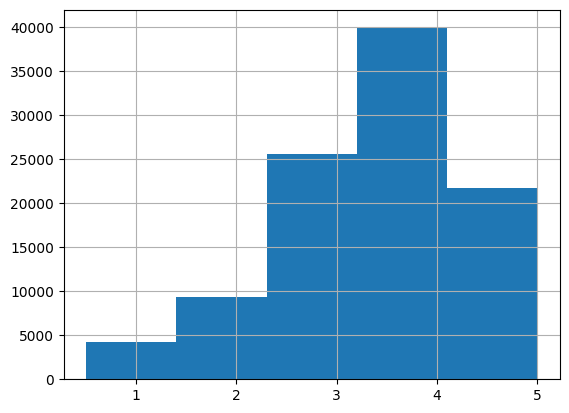

In [108]:
dataset['rating'].hist(bins=5)

In [109]:
print("The percentage of available ratings in the whole dataset is",round(dataset.rating.shape[0]/(nb_users*nb_movies)*100, 2),"%.")

The percentage of available ratings in the whole dataset is 1.7 %.


In [110]:
dataset_pivot = dataset.pivot(index='userId', columns='movieId', values='rating')

In [111]:
movies = pd.read_csv('../data/ml-latest-small/movies.csv')
movies.columns = ['old_movieId', 'title', 'genres']
df_movie_ids_map = pd.DataFrame.from_dict(movie_ids_map, 
                       orient='index')
df_movie_ids_map = df_movie_ids_map.reset_index()
df_movie_ids_map.columns = ['old_movieId','movieId']
movies_dict = pd.merge(movies, df_movie_ids_map, 
                       how='outer', on='old_movieId')
dataset_new_index = pd.merge(dataset, movies_dict, 
                             how='outer', on='movieId')

dataset_new_index[['userId', 'title', 'rating']].loc[dataset_new_index['userId']==1]

,userId,title,rating
2775,1.0,"Shawshank Redemption, The (1994)",3.0
4359,1.0,Collateral (2004),3.5
4655,1.0,Mad Max: Fury Road (2015),5.0
20148,1.0,Good Will Hunting (1997),4.5
21458,1.0,Gladiator (2000),4.0
27012,1.0,"Dark Knight, The (2008)",4.5
27084,1.0,Kill Bill: Vol. 1 (2003),4.0
37005,1.0,"Girl with the Dragon Tattoo, The (2011)",2.5
37129,1.0,Inception (2010),4.0
38538,1.0,Whiplash (2014),4.0


## Matrix Factorization with Keras

In [112]:
from keras.models import Model
from keras.layers import Embedding, Input, Reshape
from keras.layers import Dot

def get_mf_model(nb_users, nb_movies, k):
    """
    Build a simple matrix factorization model from
    the number of user, the number of movies, and the size of the embeddings k.
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization
        
    """
    dim_embedddings = k
    
    #Inputs:
    u = Input(shape=(1,), dtype='int32', name = "u__user_id")
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding")(u)
    
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    r_hat = Dot(axes = 1)([q_i, p_u])

    model = Model(inputs=[u, i], outputs=r_hat)
    
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])

    return model



In [113]:
k = 30
mf_model = get_mf_model(nb_users, nb_movies, k)

In [114]:
mf_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 i__movie_id (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 u__user_id (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 q_i__movie_embedding (Embe  (None, 1, 30)                291720    ['i__movie_id[0][0]']         
 dding)                                                                                           
                                                                                                  
 p_u__user_embedding (Embed  (None, 1, 30)                18300     ['u__user_id[0][0]']   

Let's finally train our matrix factorization model on our movieLens data. The `epochs` parameter controls the number of iterations of the SGD algorithm, that is the number of times it is going to pass on each training rating and update the embeddings accordingly. Let's keep it at 20 for the moment:

In [115]:
history = mf_model.fit(X_train, y_train, epochs=20, batch_size=512)

Epoch 1/20


178/178 [==============================] - 13s 66ms/step - loss: 13.2974 - mse: 13.2974
Epoch 2/20
178/178 [==============================] - 2s 11ms/step - loss: 11.0122 - mse: 11.0122
Epoch 3/20
178/178 [==============================] - 2s 11ms/step - loss: 5.0091 - mse: 5.0091
Epoch 4/20
178/178 [==============================] - 1s 7ms/step - loss: 2.4662 - mse: 2.4662
Epoch 5/20
178/178 [==============================] - 1s 8ms/step - loss: 1.7059 - mse: 1.7059
Epoch 6/20
178/178 [==============================] - 1s 7ms/step - loss: 1.3374 - mse: 1.3374
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 1.1215 - mse: 1.1215
Epoch 8/20
178/178 [==============================] - 1s 8ms/step - loss: 0.9819 - mse: 0.9819
Epoch 9/20
178/178 [==============================] - 1s 6ms/step - loss: 0.8852 - mse: 0.8852
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.8157 - mse: 0.8157
Epoch 11/20
178/178 [==============================]

In [116]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = mf_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

316/316 [==============================] - 1s 2ms/step
 Test RMSE : 1.0575371521841088 


## Train the same model on your GPU and on your CPU, and compare the training time

In [117]:
import tensorflow as tf

with tf.device('/cpu:0'):
    mf_model = get_mf_model(nb_users, nb_movies, k)
    history = mf_model.fit(X_train, y_train, epochs=20, batch_size=512)

Epoch 1/20
178/178 [==============================] - 9s 47ms/step - loss: 13.3192 - mse: 13.3192
Epoch 2/20
178/178 [==============================] - 2s 12ms/step - loss: 11.6056 - mse: 11.6056
Epoch 3/20
178/178 [==============================] - 1s 7ms/step - loss: 5.7219 - mse: 5.7219
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 2.6573 - mse: 2.6573
Epoch 5/20
178/178 [==============================] - 1s 8ms/step - loss: 1.7684 - mse: 1.7684
Epoch 6/20
178/178 [==============================] - 1s 6ms/step - loss: 1.3546 - mse: 1.3546
Epoch 7/20
178/178 [==============================] - 1s 6ms/step - loss: 1.1146 - mse: 1.1146
Epoch 8/20
178/178 [==============================] - 1s 5ms/step - loss: 0.9595 - mse: 0.9595
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.8523 - mse: 0.8523
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.7753 - mse: 0.7753
Epoch 11/20
178/178 [======================

## Adding user and movie bias

In [118]:
from keras.layers import Add

def get_mf_bias_model(nb_users, nb_movies, k):
    """
    Build a smatrix factorization model with user and movie biases
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization with biases
        
    """
    
    dim_embedddings = k

    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding")(u)
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    # Dot product
    d = Dot(axes = 1)([p_u, q_i])
    
    #TOFILL
    
    # Bias
    b_u = Embedding(nb_users, 1, name="b_u__user_bias")(u)
    b_u = Reshape((1,), name="b_u__user_bias_reshaped")(b_u)
    b_i = Embedding(nb_movies, 1, name="b_u__movie_bias")(u)
    b_i = Reshape((1,), name="b_u__movie_bias_reshaped")(b_i)
    
    r_hat = Add()([b_u, b_i, d])

    model = Model(inputs=[u,i], outputs=r_hat)

    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    return model



In [119]:
mf_bias_model = get_mf_bias_model(nb_users, nb_movies, k)

In [120]:
mf_bias_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 u__user_id (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 i__movie_id (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 p_u__user_embedding (Embed  (None, 1, 30)                18300     ['u__user_id[0][0]']          
 ding)                                                                                            
                                                                                                  
 q_i__movie_embedding (Embe  (None, 1, 30)                291720    ['i__movie_id[0][0]']  

In [121]:
history = mf_bias_model.fit(X_train, y_train, epochs=20, batch_size=512)


Epoch 1/20


178/178 [==============================] - 23s 123ms/step - loss: 12.4146 - mse: 12.4146
Epoch 2/20
178/178 [==============================] - 3s 16ms/step - loss: 9.3618 - mse: 9.3618
Epoch 3/20
178/178 [==============================] - 3s 17ms/step - loss: 3.9743 - mse: 3.9743
Epoch 4/20
178/178 [==============================] - 3s 18ms/step - loss: 1.8820 - mse: 1.8820
Epoch 5/20
178/178 [==============================] - 2s 11ms/step - loss: 1.3144 - mse: 1.3144
Epoch 6/20
178/178 [==============================] - 2s 13ms/step - loss: 1.0541 - mse: 1.0541
Epoch 7/20
178/178 [==============================] - 2s 12ms/step - loss: 0.9075 - mse: 0.9075
Epoch 8/20
178/178 [==============================] - 2s 10ms/step - loss: 0.8140 - mse: 0.8140
Epoch 9/20
178/178 [==============================] - 2s 11ms/step - loss: 0.7501 - mse: 0.7501
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.7041 - mse: 0.7041
Epoch 11/20
178/178 [==========================

In [122]:
y_pred = mf_bias_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

316/316 [==============================] - 1s 2ms/step
 Test RMSE : 0.9511975559098056 


## Adding L2 regularization

In [123]:
from keras import regularizers

def get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_):
    """
    Build a smatrix factorization model with user and movie biases, and L2 regularization
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization with biases
            and L2 regularization
        
    """
    
    
    #TOFILL
    
    dim_embedddings = k

    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding",
                    embeddings_regularizer=regularizers.l2(lambda_))(u)
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding",
                    embeddings_regularizer=regularizers.l2(lambda_))(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    # Dot product
    d = Dot(axes = 1)([p_u, q_i])
    
    #TOFILL
    
    # Bias
    b_u = Embedding(nb_users, 1, name="b_u__user_bias",
                    embeddings_regularizer=regularizers.l2(0.01))(u)
    b_u = Reshape((1,), name="b_u__user_bias_reshaped")(b_u)
    b_i = Embedding(nb_movies, 1, name="b_u__movie_bias",
                    embeddings_regularizer=regularizers.l2(0.01))(u)
    b_i = Reshape((1,), name="b_u__movie_bias_reshaped")(b_i)
    
    r_hat = Add()([b_u, b_i, d])

    model = Model(inputs=[u,i], outputs=r_hat)

    model.compile(loss='mse', optimizer='adam', metrics=['mse'])   

    
    return model



In [124]:
lambda_ = 0.00001
mf_bias_reg_model = get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_)

In [125]:
mf_bias_reg_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 u__user_id (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 i__movie_id (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 p_u__user_embedding (Embed  (None, 1, 30)                18300     ['u__user_id[0][0]']          
 ding)                                                                                            
                                                                                                  
 q_i__movie_embedding (Embe  (None, 1, 30)                291720    ['i__movie_id[0][0]']  

In [126]:
history = mf_bias_reg_model.fit(X_train, y_train, epochs=20, batch_size=512)


Epoch 1/20


178/178 [==============================] - 2s 4ms/step - loss: 12.5106 - mse: 12.4629
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 9.2890 - mse: 9.0822
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 4.1633 - mse: 3.7827
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 2.4094 - mse: 2.0027
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 1.8294 - mse: 1.4746
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 1.5084 - mse: 1.2112
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 1.3046 - mse: 1.0534
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 1.1672 - mse: 0.9480
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 1.0711 - mse: 0.8724
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 1.0005 - mse: 0.8153
Epoch 11/20
178/178 [==============================] - 1s 

In [127]:
y_pred = mf_bias_reg_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

316/316 [==============================] - 1s 2ms/step
 Test RMSE : 1.0462710948156075 


## Early Stopping

In [128]:
from keras.callbacks import EarlyStopping

mf_bias_reg_model = get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_)

early_stopping = EarlyStopping(monitor='val_mse', patience=5, verbose=1, restore_best_weights=True)

history = mf_bias_reg_model.fit(X_train, y_train, epochs=500, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/500
160/160 [==============================] - 2s 6ms/step - loss: 12.5824 - mse: 12.5374 - val_loss: 11.8338 - val_mse: 11.7412
Epoch 2/500
160/160 [==============================] - 1s 5ms/step - loss: 10.3108 - mse: 10.1300 - val_loss: 8.1202 - val_mse: 7.8403
Epoch 3/500
160/160 [==============================] - 1s 5ms/step - loss: 5.5703 - mse: 5.2064 - val_loss: 3.8051 - val_mse: 3.3784
Epoch 4/500
160/160 [==============================] - 1s 4ms/step - loss: 2.8880 - mse: 2.4497 - val_loss: 2.5785 - val_mse: 2.1459
Epoch 5/500
160/160 [==============================] - 1s 4ms/step - loss: 2.0786 - mse: 1.6715 - val_loss: 2.0999 - val_mse: 1.7219
Epoch 6/500
160/160 [==============================] - 1s 5ms/step - loss: 1.6718 - mse: 1.3237 - val_loss: 1.8247 - val_mse: 1.5057
Epoch 7/500
160/160 [==============================] - 1s 5ms/step - loss: 1.4154 - mse: 1.1217 - val_loss: 1.6539 - val_mse: 1.3840
Epoch 8/500
160/160 [==============================] - 1s 4ms/s

## Grid search embedding size and regularization factor with early stopping

In [129]:
import itertools
from sklearn.model_selection import GridSearchCV

def grid_search(data, param_grid, get_model_function, nb_users, nb_movies, validation_size = 0.1):
    """
    Performs a grid search over the 
    
    Input:
        data : DataFrame : The training set to be split between training and validation sets
        param_grid : dict : Dictionary containing the values of the hyper-parameters to grid-search
        get_model_function : function : A function that returns the keras model to grid-search
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        validation_size : float : Proportion of the validation set
        
    Output:
        best_params : dict : A dictionary of the best hyper-parameters values
        best_score : float : The validation RMSE corresponding to the best
        best_model : keras.Model : The model trained with the best hyper-parameters
        
    """
    
    best_score = np.inf
    best_params = {}
    best_model = None
    
    #TOFILL

    # Data
    X = [data["userId"].to_numpy(), train["movieId"].to_numpy()]
    y = data["rating"].to_numpy()

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_mse', 
                                   patience=5, verbose=1, 
                                   restore_best_weights=True)
    
    # Models
    for k in list(param_grid.values())[0]:
        for l in list(param_grid.values())[1]:
            model = get_model_function(nb_users, nb_movies, k, l)
            result = model.fit(X, y,
                               epochs=500, batch_size=512,
                               validation_split=validation_size,
                               callbacks=[early_stopping])
            #print(result.result.keys())

            
            mse = result.history['mse'] #list
            min_mse = min(mse) #scalar
            rmse = sqrt(min_mse) #scalar

            rmse = sqrt(min(result.history['mse']))
            if rmse < best_score:
                best_score = rmse
                best_params['k'] = k
                best_params['lambda_'] = l
                best_model = model

    """
    # Grid search
    grid_search = GridSearchCV(model_function, param_grid, cv=5,
                           scoring="neg_root_mean_squared_error",
                           n_jobs=-1)
    grid_result = grid_search.fit(X_train, y_train, 
                                  validation_data=(X_val, y_val), 
                                  callbacks=[early_stopping])
    """
    
    return best_params, best_score, best_model

In [130]:
lambdas_ = [0.0002, 0.00005, 0.00002]
ks = [15,30]

param_grid = dict(k=ks, lambda_=lambdas_)

best_params, best_score, best_model = grid_search(train, param_grid,
                                                  get_mf_bias_l2_reg_model,
                                                  nb_users, nb_movies, validation_size = 0.1)


Epoch 1/500
160/160 [==============================] - 2s 6ms/step - loss: 12.6056 - mse: 12.5559 - val_loss: 11.8844 - val_mse: 11.7888
Epoch 2/500
160/160 [==============================] - 1s 5ms/step - loss: 10.7482 - mse: 10.5314 - val_loss: 9.2418 - val_mse: 8.8591
Epoch 3/500
160/160 [==============================] - 1s 5ms/step - loss: 7.3912 - mse: 6.7882 - val_loss: 5.8419 - val_mse: 5.0129
Epoch 4/500
160/160 [==============================] - 1s 4ms/step - loss: 4.8347 - mse: 3.8222 - val_loss: 4.3318 - val_mse: 3.1662
Epoch 5/500
160/160 [==============================] - 1s 5ms/step - loss: 3.8984 - mse: 2.6415 - val_loss: 3.8441 - val_mse: 2.5152
Epoch 6/500
160/160 [==============================] - 1s 4ms/step - loss: 3.5305 - mse: 2.1585 - val_loss: 3.6075 - val_mse: 2.2008
Epoch 7/500
160/160 [==============================] - 1s 5ms/step - loss: 3.3259 - mse: 1.8951 - val_loss: 3.4671 - val_mse: 2.0135
Epoch 8/500
160/160 [==============================] - 1s 4ms/s

In [131]:
print('Best hyper-parameters : ' + str(best_params))
print('Best validation RMSE : ' + str(best_score))

Best hyper-parameters : {'k': 30, 'lambda_': 2e-05}
Best validation RMSE : 0.7461054136952344


In [132]:
y_pred = best_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print("Best model test RMSE : %s " % test_rmse)

316/316 [==============================] - 1s 2ms/step
Best model test RMSE : 1.0699221396175655 


## Retrain on all the dataset with the best hyper-parameters

In [133]:
from keras.callbacks import EarlyStopping

X = [dataset["userId"].to_numpy(), dataset["movieId"].to_numpy()]
y = dataset["rating"].to_numpy()

#TOFILL
best_model=get_mf_bias_l2_reg_model(nb_users, nb_movies, k =best_params['k'], lambda_ =best_params['lambda_'])

early_stopping = EarlyStopping(monitor='val_mse', patience=10, verbose=1, restore_best_weights=True)

best_model.fit(X, y, epochs=500, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/500
178/178 [==============================] - 3s 6ms/step - loss: 12.4650 - mse: 12.4124 - val_loss: 11.6321 - val_mse: 11.5190
Epoch 2/500
178/178 [==============================] - 1s 5ms/step - loss: 9.3709 - mse: 9.1489 - val_loss: 6.5180 - val_mse: 6.1770
Epoch 3/500
178/178 [==============================] - 1s 5ms/step - loss: 4.2867 - mse: 3.8638 - val_loss: 3.1235 - val_mse: 2.6497
Epoch 4/500
178/178 [==============================] - 1s 5ms/step - loss: 2.5080 - mse: 2.0355 - val_loss: 2.3193 - val_mse: 1.8598
Epoch 5/500
178/178 [==============================] - 1s 5ms/step - loss: 1.9299 - mse: 1.4941 - val_loss: 1.9499 - val_mse: 1.5395
Epoch 6/500
178/178 [==============================] - 1s 5ms/step - loss: 1.6151 - mse: 1.2272 - val_loss: 1.7344 - val_mse: 1.3670
Epoch 7/500
178/178 [==============================] - 1s 5ms/step - loss: 1.4174 - mse: 1.0664 - val_loss: 1.6012 - val_mse: 1.2645
Epoch 8/500
178/178 [==============================] - 1s 5ms/ste

## Recommend the top-5 movies for the 10 first users

In [134]:
def get_top5_for_user(model, user_id, dataset):
    """
    Returns a list of the 5 movies that have the highest ratings among the unrated movies
    of user `user_id`, along with a list of their predicted ratings.
    
    Input :
        model : keras.models.Model : A trained matrix factorization model
        user_id : int : The user id to use
        dataset : DataFrame : The whole dataset, useful to find the movies 
            the user `user_id` has already rated
    
    Output :
        five_best_movie_ids : list : The five movie ids among unrated movies by user `user_id` 
            that have the highest predicted ratings, in order
        five_best_ratings : list : The corresponding five ratings
    """
    
    X = [dataset["userId"].to_numpy(), dataset["movieId"].to_numpy()]
    ind = X[0] == user_id
    unseen_movies = np.unique(X[1][~ind])
    user_repeated = np.full_like(unseen_movies, user_id)
    X_norating = [user_repeated, unseen_movies]


    # Predict
    y_pred = model.predict(X_norating)

    # Top-5 movies
    norating_user_movies = pd.DataFrame({'movieId': unseen_movies,
                              'predicted_rating': np.concatenate(y_pred)})
    norating_user_movies = norating_user_movies.sort_values(by='predicted_rating', ascending=False)
    five_best_movie_ids = norating_user_movies['movieId'].head(5)
    five_best_ratings = norating_user_movies['predicted_rating'].head(5)

    return five_best_movie_ids, five_best_ratings

In [136]:
#TOFILL

five_best_titles = pd.DataFrame(columns=['movieId', 'rating', 'old_movieId', 'title', 'genres', 'userId'])

for user in range(10):
    movies, ratings = get_top5_for_user(best_model, user, dataset)
    five_best = pd.DataFrame({'movieId': movies,
                              'rating': ratings})
    user_five_best_titles = pd.merge(five_best, movies_dict, 
                             how='inner', on='movieId')
    user_five_best_titles['userId'] = user
    five_best_titles = pd.concat([five_best_titles, user_five_best_titles])
    print(f"\nFirst best movies for user {user} \n",
          five_best_titles[['title', 'rating']])

  1/304 [..............................] - ETA: 9s

304/304 [==============================] - 1s 2ms/step

First best movies for user 0 
                                              title    rating
0                 Streetcar Named Desire, A (1951)  5.546659
1                 Shawshank Redemption, The (1994)  5.536927
2  Grand Day Out with Wallace and Gromit, A (1989)  5.408100
3                             Touch of Evil (1958)  5.380454
4                 Drunken Master (Jui kuen) (1978)  5.368370
 23/304 [=>............................] - ETA: 0s

/tmp/ipykernel_59305/2835021776.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  five_best_titles = pd.concat([five_best_titles, user_five_best_titles])


304/304 [==============================] - 1s 2ms/step

First best movies for user 1 
                                               title    rating
0                  Streetcar Named Desire, A (1951)  5.546659
1                  Shawshank Redemption, The (1994)  5.536927
2   Grand Day Out with Wallace and Gromit, A (1989)  5.408100
3                              Touch of Evil (1958)  5.380454
4                  Drunken Master (Jui kuen) (1978)  5.368370
0                  Shawshank Redemption, The (1994)  4.401474
1   Grand Day Out with Wallace and Gromit, A (1989)  4.376336
2                  Streetcar Named Desire, A (1951)  4.338771
3                                Hoop Dreams (1994)  4.285019
4  Three Billboards Outside Ebbing, Missouri (2017)  4.277138
304/304 [==============================] - 1s 2ms/step

First best movies for user 2 
                                               title    rating
0                  Streetcar Named Desire, A (1951)  5.546659
1                  S

In [137]:
five_best_titles['title'].value_counts()

title
Streetcar Named Desire, A (1951)                    8
Shawshank Redemption, The (1994)                    8
Grand Day Out with Wallace and Gromit, A (1989)     7
Hoop Dreams (1994)                                  6
Drunken Master (Jui kuen) (1978)                    3
Forrest Gump (1994)                                 3
Schindler's List (1993)                             3
Three Billboards Outside Ebbing, Missouri (2017)    2
Braveheart (1995)                                   2
Guess Who's Coming to Dinner (1967)                 1
In the Name of the Father (1993)                    1
Touch of Evil (1958)                                1
Trial, The (Procès, Le) (1962)                      1
Godfather: Part II, The (1974)                      1
Casablanca (1942)                                   1
Fugitive, The (1993)                                1
Lion King, The (1994)                               1
Name: count, dtype: int64

## Visualize the embeddings

### PCA

In [193]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

#TOFILL
scaler = StandardScaler()
user_embedding = best_model.get_layer('p_u__user_embedding').get_weights()
user_embedding_scaled = scaler.fit_transform(user_embedding[0])
movie_embedding = best_model.get_layer('q_i__movie_embedding').get_weights()
movie_embedding_scaled = scaler.fit_transform(movie_embedding[0])

pca = PCA()
pca_results = pca.fit_transform(movie_embedding_scaled)

In [199]:
movies_dict = movies_dict.sort_values(by='movieId')
df_pca_results = pd.merge(pd.DataFrame(pca_results), 
                                     movies_dict, 
                                     left_index=True, 
                                     right_index=True)

In [236]:
col_names = []
for i in range(30):
    name = 'pca' + str(i+1)
    col_names.append(name)
col_names.extend(movies_dict.columns.to_list())
df_pca_results.columns = col_names

In [253]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_*100)

fig = px.scatter(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Cumulative Explained Variance (%)"}
)
fig.update_traces(mode='lines+markers')
fig.layout.title = 'PCA on movies: Explained Variance Ratio'
fig.show()

In [252]:
fig = px.scatter(
    x=df_pca_results['pca1'], 
    y=df_pca_results['pca2'],
    hover_name=df_pca_results['title'])
fig.update_layout(
    title="Principal Component Analysis",
    xaxis_title="Component 1",
    yaxis_title="Component 2"
)
fig.show()

---

In [260]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_silhouette_score(c, data):
    clusterer = KMeans(n_clusters=c, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(data)
    return silhouette_score(data, cluster_labels)

def plot_silhouette_score(data, range_max):
    clusters = []
    silhouette_scores = []
    range_max = range_max+1
    for c in range(2,range_max):
        clusters.append(c)
        silhouette_scores.append(get_silhouette_score(c, data))
    df_silhouette = pd.DataFrame(
    {'clusters': clusters,
     'Silhouette scores': silhouette_scores
    })
    #df_silhouette = df_silhouette.set_index('clusters')

    fig = px.scatter(
        x=df_silhouette['clusters'],
        y=df_silhouette['Silhouette scores'],
        labels={"x": "Clusters", "y": "Silhouette scores"}
    )
    fig.update_traces(mode='lines+markers')
    fig.layout.title = 'Sihouette Score for KMeans Clustering'
    fig.show()

In [261]:
plot_silhouette_score(df_pca_results.loc[:,'pca1':'pca30'], 10)

In [265]:
optimal_number_of_clusters = 3

kmeans = KMeans(n_clusters=optimal_number_of_clusters, random_state=0, n_init="auto")
kmeans.fit(df_pca_results.loc[:,'pca1':'pca30'])
labels = kmeans.predict(df_pca_results.loc[:,'pca1':'pca30'])

In [266]:
df_pca_results['Cluster'] = labels.astype(str)
fig = px.scatter(
    df_pca_results, x='pca1', y='pca2', hover_name='title', color='Cluster'
)
fig.update_layout(
    title='Visualization of Movies Clusters from KMeans Clustering on PCA',
    xaxis_title="Component 1",
    yaxis_title="Component 2"
)
fig.show()